# Übung 4: Supportvektormaschinen mit SciKit Learn, Random Forests und Boosting

## 1. Klassifikation mit SVMs

In [1]:
%matplotlib inline
import random
import time
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn.metrics import classification_report
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import skimage as ski
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits import mplot3d

np.set_printoptions(suppress=True, linewidth=np.inf)
sns.set_style("darkgrid")

%reload_ext version_information
%version_information numpy, pandas, seaborn, sklearn, skimage, random, matplotlib, mpl_toolkits

Software,Version
Python,3.7.4 64bit [GCC 7.3.0]
IPython,7.8.0
OS,Linux 4.15.0 70 generic x86_64 with debian buster sid
numpy,1.17.2
pandas,0.25.1
seaborn,0.9.0
sklearn,0.21.3
skimage,0.15.0
random,The 'random' distribution was not found and is required by the application
matplotlib,3.1.1


### a) Einlesen, Vorverarbeiten und Anzeigen der Daten

/home/henning/anaconda3/envs/base_mldl/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


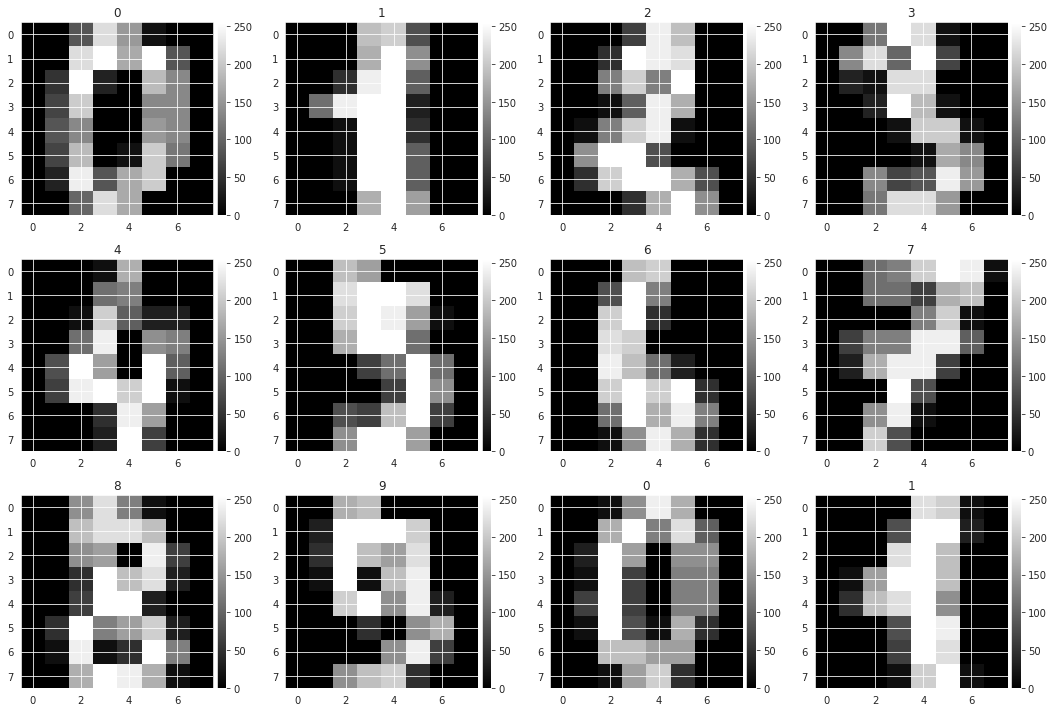

In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

digits = load_digits()
data = digits.data
labels = digits.target
n, d = data.shape

ncols, nrows = 4, 3
fig = plt.figure(figsize=(15,10))
spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
for i in range(nrows):
    for j in range(ncols):
        ax = fig.add_subplot(spec[i, j])
        ax.set_title(labels[i * ncols + j])
        img = (data[i * ncols + j]*(255/data[i * ncols + j].max())).astype(int)
        ski.io.imshow(img.reshape(8,8), ax=ax, cmap="gray")

### b) Mit SVM-Klassifikator arbeiten

In [3]:
def shuffle(data, labels):
    mixer = list(zip(data, labels))
    random.shuffle(mixer)
    data, labels = zip(*mixer)
    return data, labels

In [4]:
def sample_data(n_test, data, labels):
    data = np.asarray(data)
    n, d = data.shape
    n_train = n - n_test
    train_data = data[:n_train]
    test_data = data[n_train:]
    train_labels = labels[:n_train]
    test_labels = labels[n_train:]
    return train_data, test_data, train_labels, test_labels

In [5]:
def train_svm(train_data, train_labels, test_data, test_labels, C, gamma, precision=3, printout=False):
    svm = SVC(C=C, gamma=gamma)
    svm.fit(train_data, train_labels)
    train_score = svm.score(train_data, train_labels)
    test_score = svm.score(test_data, test_labels)
    
    if printout:
        print("Train/Test ratio: ~{:1.2f}, C: {}, gamma: {}".format(len(test_data) / (len(test_data) + len(train_data)), C, gamma))
        if train_score < test_score:
            print("Underfitting! Train score is smaller then test score. train-accuracy: {}, test-accuracy: {:1.3f}".format(train_score, test_score))
        elif train_score > test_score:
            print("Overfitting! Train score is higher then test score. train-accuracy: {}, test-accuracy: {:1.3f}".format(train_score, test_score))
        else:
            print("Perfect! Train score is equal to the test score. train-accuracy: {}, test-accuracy: {:1.3f}".format(train_score, test_score))   
        print()
    
    return train_score, test_score

In [6]:
data, labels = shuffle(data, labels)

# Test1
n_test = int(n * 0.25)
train_data, test_data, train_labels, test_labels = sample_data(n_test, data, labels)

C = 1.0
gamma = 0.015
train_svm(train_data, train_labels, test_data, test_labels, C, gamma, printout=True)
    
C = 100
gamma = 0.001
_, _ = train_svm(train_data, train_labels, test_data, test_labels, C, gamma, printout=True)

# Test2
n_test = int(n * 0.5)
train_data, test_data, train_labels, test_labels = sample_data(n_test, data, labels)
    
C = 100
gamma = 0.001
_, _ = train_svm(train_data, train_labels, test_data, test_labels, C, gamma, printout=True)

# Test3
n_test = int(n * 0.75)
train_data, test_data, train_labels, test_labels = sample_data(n_test, data, labels)
    
C = 100
gamma = 0.001
_, _ = train_svm(train_data, train_labels, test_data, test_labels, C, gamma, printout=True)

Train/Test ratio: ~0.25, C: 1.0, gamma: 0.015
Overfitting! Train score is higher then test score. train-accuracy: 1.0, test-accuracy: 0.452

Train/Test ratio: ~0.25, C: 100, gamma: 0.001
Overfitting! Train score is higher then test score. train-accuracy: 1.0, test-accuracy: 0.982

Train/Test ratio: ~0.50, C: 100, gamma: 0.001
Overfitting! Train score is higher then test score. train-accuracy: 1.0, test-accuracy: 0.984

Train/Test ratio: ~0.75, C: 100, gamma: 0.001
Overfitting! Train score is higher then test score. train-accuracy: 1.0, test-accuracy: 0.983



#### A: Das Ergebnis hängt stark von der zufälligen Sortierung ab und kann deswegen schwanken. Es lässt sich nicht generell sagen bei welchem Training/Test-Verhältnis die höchste Treffergenauigkeit zu erwarten ist.

## 2. Kreuzvalidierung und Modellselektion

### a) SVM mit verschiedenen Splits

In [7]:
C = 100
gamma = 0.001
train_scores = []
test_scores = []
n_splits = 10
for i in range(n_splits):
    data, labels = shuffle(data, labels)
    n_test = int(n * 0.25)
    train_data, test_data, train_labels, test_labels = sample_data(n_test, data, labels)
    train_score, test_score = train_svm(train_data, train_labels, test_data, test_labels, C, gamma, printout=True)
    train_scores.append(train_score)
    test_scores.append(test_score)
mean_train_score = np.mean(train_scores)
mean_test_score = np.mean(test_scores)
std_train_score = np.std(train_scores)
std_test_score = np.std(test_scores)
print("mean train-accuracy: {:1.3f}, train-std: {:1.3f}".format(mean_train_score, std_train_score))
print("mean test-accuracy: {:1.3f}, test-std: {:1.3f}".format(mean_test_score, std_test_score))

Train/Test ratio: ~0.25, C: 100, gamma: 0.001
Overfitting! Train score is higher then test score. train-accuracy: 1.0, test-accuracy: 0.993

Train/Test ratio: ~0.25, C: 100, gamma: 0.001
Overfitting! Train score is higher then test score. train-accuracy: 1.0, test-accuracy: 0.993

Train/Test ratio: ~0.25, C: 100, gamma: 0.001
Overfitting! Train score is higher then test score. train-accuracy: 1.0, test-accuracy: 0.989

Train/Test ratio: ~0.25, C: 100, gamma: 0.001
Overfitting! Train score is higher then test score. train-accuracy: 1.0, test-accuracy: 0.998

Train/Test ratio: ~0.25, C: 100, gamma: 0.001
Overfitting! Train score is higher then test score. train-accuracy: 1.0, test-accuracy: 0.987

Train/Test ratio: ~0.25, C: 100, gamma: 0.001
Overfitting! Train score is higher then test score. train-accuracy: 1.0, test-accuracy: 0.993

Train/Test ratio: ~0.25, C: 100, gamma: 0.001
Overfitting! Train score is higher then test score. train-accuracy: 1.0, test-accuracy: 0.987

Train/Test ra

### b) Kreuzvalidierung mit SciKit-Methode

In [8]:
data, labels = shuffle(data, labels)
n_test = int(n * 0.25)
train_data, test_data, train_labels, test_labels = sample_data(n_test, data, labels)

C = 100
gamma = 0.001
svm = SVC(C=C, gamma=gamma)
train_scores = cross_val_score(svm, train_data, train_labels, cv=10)
mean_train_score = np.mean(train_scores)
std_train_score = np.std(train_scores)
print("mean train-accuracy: {:1.3f}, train-std: {:1.3f}".format(mean_train_score, std_train_score))

mean train-accuracy: 0.989, train-std: 0.008


### c) GridSearch von "Hand"

In [9]:
n_small = 500
data_small = data[:n_small]
labels_small = labels[:n_small]

n_Cs = 3
min_C, max_C = 5, 15
Cs = np.linspace(min_C, max_C, n_Cs)

n_gammas = 10
min_gamma, max_gamma = -7, -1
gammas = np.logspace(min_gamma,  max_gamma, n_gammas)

n_test = int(n_small * 0.5)
n_splits = 5

plot_data_train = np.zeros(shape=(n_gammas, n_Cs), dtype=np.float)
plot_data_test = np.zeros(shape=(n_gammas, n_Cs), dtype=np.float)

max_mean, max_gamma, max_C = 0.0, 0.0, 0.0
for i, gamma in enumerate(gammas):
    for j, C in enumerate(Cs):
        scores_train = 0.0
        scores_test = 0.0
        for _ in range(n_splits):
            data_small, labels_small = shuffle(data_small, labels_small)
            train_data, test_data, train_labels, test_labels = sample_data(n_test, data_small, labels_small)
            train_score, test_score = train_svm(train_data, train_labels, test_data, test_labels, C, gamma)
            scores_train += train_score
            scores_test += test_score
        mean_test = (scores_test/n_splits)
        plot_data_train[i, j] = (scores_train/n_splits)
        plot_data_test[i, j] = mean_test
        
        if mean_test > max_mean:
            max_mean = mean_test
            max_gamma = gamma
            max_C = C
print("Best parameters: (C: {}, gamma: {})".format(max_C, max_gamma))
print("Best score: {:1.3f}".format(max_mean))

Best parameters: (C: 15.0, gamma: 0.001)
Best score: 0.968


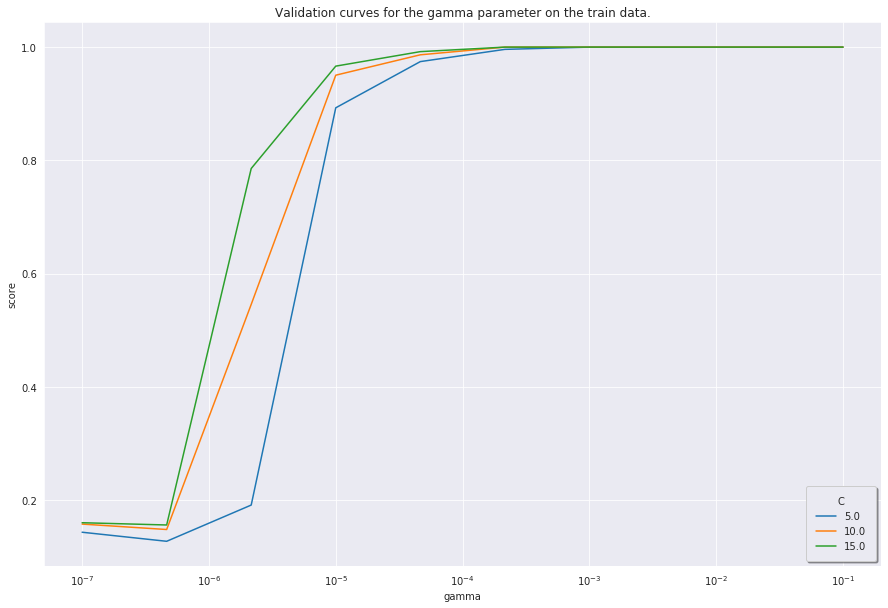

In [10]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))
for i, C in enumerate(Cs):
    ax = sns.lineplot(x=gammas, y=plot_data_train[:, i], label=C)
    ax.set(xscale="log")
    ax.set_title('Validation curves for the gamma parameter on the train data.');
    ax.set_xlabel("gamma")
    ax.set_ylabel("score")
    ax.legend(loc="lower right", fancybox=True, framealpha=1, shadow=True, borderpad=1, title="C")

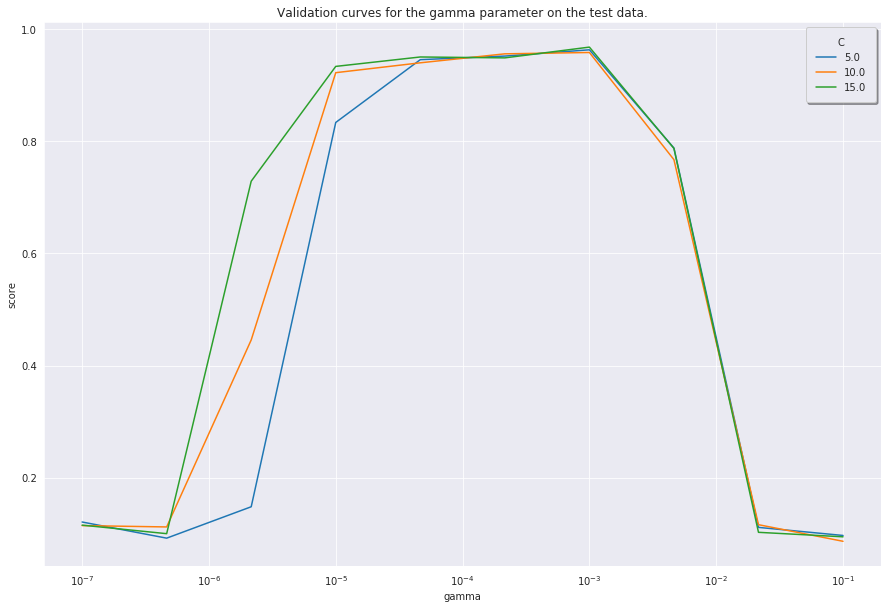

In [11]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))
for i, C in enumerate(Cs):
    ax = sns.lineplot(x=gammas, y=plot_data_test[:, i], label=C)
    ax.set(xscale="log")
    ax.set_title('Validation curves for the gamma parameter on the test data.');
    ax.set_xlabel("gamma")
    ax.set_ylabel("score")
    ax.legend(loc="upper right", fancybox=True, framealpha=1, shadow=True, borderpad=1, title="C")

In [12]:
# %matplotlib notebook
# import seaborn as sns
# import matplotlib.pyplot as plt
# from mpl_toolkits import mplot3d

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# X, Y = np.meshgrid(gammas, Cs)
# ax.plot_surface(X, Y, plot_data_test, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
# ax.set_title('surface')
# ax.set_xlabel("gamma")
# ax.set_ylabel("C")
# ax.set_zlabel("score")

### d) GridSearch mit SciKit

In [13]:
n_small = 500
data_small = data[:n_small]
labels_small = labels[:n_small]

n_Cs = 4
min_C, max_C = -1, 2
Cs = np.logspace(min_C, max_C, n_Cs)

n_gammas = 5
min_gamma, max_gamma = -4, 0
gammas = np.logspace(min_gamma,  max_gamma, n_gammas)

n_test = int(n_small * 0.5)
n_splits = 3

train_data, test_data, train_labels, test_labels = sample_data(n_test, data_small, labels_small)

svc_params = {'C': Cs,'gamma': gammas}
gridsvm = sklearn.model_selection.GridSearchCV(SVC(), param_grid=svc_params, cv=n_splits)
gridsvm.fit(train_data, train_labels)
y_true, y_pred = test_labels, gridsvm.predict(test_data)

print(f"Best parameters: {gridsvm.best_params_}")
print(f"Best score: {gridsvm.best_score_}")
print()
print("Classification report:")
print(classification_report(y_true, y_pred))

Best parameters: {'C': 10.0, 'gamma': 0.001}
Best score: 0.944

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.90      1.00      0.95        27
           2       1.00      1.00      1.00        30
           3       0.91      1.00      0.95        21
           4       0.96      1.00      0.98        24
           5       0.97      0.91      0.94        33
           6       1.00      0.96      0.98        25
           7       1.00      0.96      0.98        24
           8       0.95      0.95      0.95        22
           9       0.96      0.93      0.95        28

    accuracy                           0.96       250
   macro avg       0.97      0.96      0.96       250
weighted avg       0.97      0.96      0.96       250



/home/henning/anaconda3/envs/base_mldl/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## 3. Klassifikation mit Random Forests und Boosting

### a) Klassifikator mit Random Forest

In [14]:
n_iterations = 100
n_estimators = 50
max_depth = 4

oob_errors = []
error_rates = []

start = time.time()
for i in range(n_iterations):
    n_small = 500
    data_small = data[:n_small]
    labels_small = labels[:n_small]

    data, labels = shuffle(data, labels)
    n_test = int(n_small * 0.5)
    train_data, test_data, train_labels, test_labels = sample_data(n_test, data, labels)

    rndf = RandomForestClassifier(n_estimators, max_depth=max_depth, random_state=0, oob_score=True)
    rndf.fit(train_data, train_labels)
    y_true, y_pred = test_labels, rndf.predict(test_data)
    best_score = rndf.score(test_data, test_labels)
    error_rate = 1 - best_score
    oob_error = 1 - rndf.oob_score_
    oob_errors.append(oob_error)
    error_rates.append(error_rate)
stop = time.time()
print("Elapsed time: {:1.2f} mins.".format((stop - start) / 60))

Elapsed time: 0.22 mins.


In [15]:
print("Best score: {:1.3f}, error_rate: {:1.3f}, out-of-bag error: {:1.3f}".format(best_score, error_rate, oob_error))
print()
print("Classification report:")
print(classification_report(y_true, y_pred))

Best score: 0.876, error_rate: 0.124, out-of-bag error: 0.118

Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        22
           1       0.83      0.75      0.79        32
           2       0.81      0.88      0.84        24
           3       0.79      0.96      0.86        23
           4       0.93      0.96      0.95        28
           5       0.92      0.81      0.86        27
           6       0.86      0.95      0.90        19
           7       0.88      1.00      0.94        23
           8       1.00      0.74      0.85        27
           9       0.87      0.80      0.83        25

    accuracy                           0.88       250
   macro avg       0.88      0.88      0.88       250
weighted avg       0.88      0.88      0.87       250



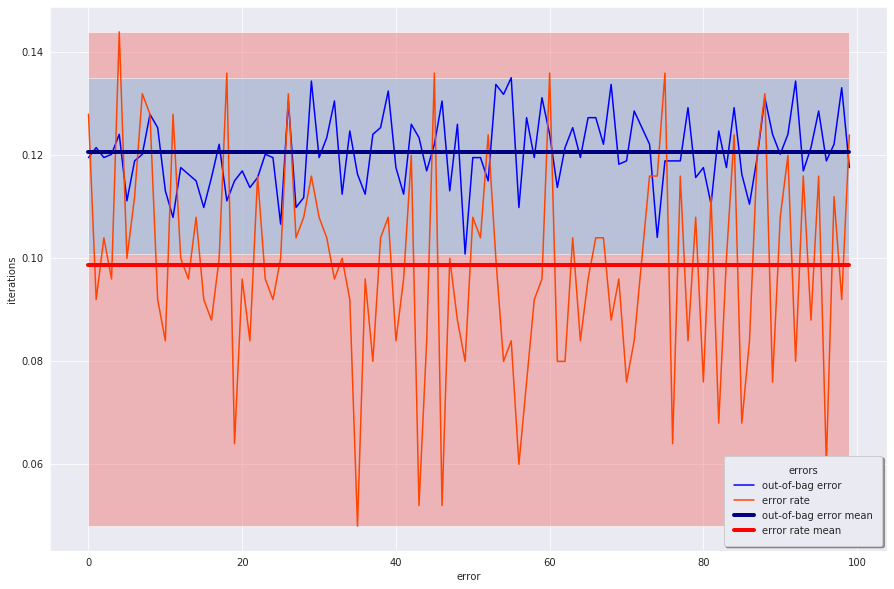

In [16]:
fig = plt.figure(figsize=(15, 10))
x = np.arange(0, n_iterations, 1)

obb_mean = np.mean(oob_errors)
error_rate_mean = np.mean(error_rates)
obb_error_min, obb_error_max = min(oob_errors), max(oob_errors)
error_rate_min, error_rate_max = min(error_rates), max(error_rates)

ax = sns.lineplot(x, y=oob_errors, label='out-of-bag error', color='blue')
ax = sns.lineplot(x, y=error_rates, label='error rate', color='orangered')

ax = sns.lineplot(x, y=obb_mean, label='out-of-bag error mean', color='navy', linewidth=4)
ax = sns.lineplot(x, y=error_rate_mean, label='error rate mean', color='red', linewidth=4)

ax.fill_between(x, error_rate_min, error_rate_max, facecolor='lightcoral', alpha=0.5)
ax.fill_between(x, obb_error_min, obb_error_max, facecolor='lightskyblue', alpha=0.5)

ax.set_xlabel("error")
ax.set_ylabel("iterations")
ax.legend(loc="lower right", fancybox=True, framealpha=1, shadow=True, borderpad=1, title="errors")

#### - Der out-of-bag error bleibt bei mehrfacher Ausführung konstant. 
#### - Die Fehlerrate schwankt stärker. 
#### - Der out-of-bag error  error ist im Mittelwert höher als die Fehlerrate.

### b) Random Forest mit Boosting

In [17]:
n_estimators = 50
max_depth = 4

boost = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
boost.fit(train_data, train_labels)
best_score = boost.score(test_data, test_labels)
error_rate = 1 - best_score

print(f"Best score: {best_score}")
print()
print("Classification report:")
print(classification_report(y_true, y_pred))

Best score: 0.96

Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        22
           1       0.83      0.75      0.79        32
           2       0.81      0.88      0.84        24
           3       0.79      0.96      0.86        23
           4       0.93      0.96      0.95        28
           5       0.92      0.81      0.86        27
           6       0.86      0.95      0.90        19
           7       0.88      1.00      0.94        23
           8       1.00      0.74      0.85        27
           9       0.87      0.80      0.83        25

    accuracy                           0.88       250
   macro avg       0.88      0.88      0.88       250
weighted avg       0.88      0.88      0.87       250



### OPTIONAL: GridSearch für Random Forest mit Boosting 

In [20]:
estimators = np.arange(10, 250, 25)
depths = np.arange(1, 5, 1)

n_ = len(estimators)
d_ = len(depths)

print("Number of trees: {}".format(estimators))
print("Number of depths: {}".format(depths))

min_error = np.inf
min_params = None
errors = np.zeros(shape=(d_, n_))

start = time.time()
for i, max_depth in enumerate(depths):
    for j, n_estimators in enumerate(estimators):
        boost = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
        boost.fit(train_data, train_labels)
        best_score = boost.score(test_data, test_labels)
        error = 1 - best_score
        
        errors[i, j] = error
        
        if error < min_error:
            min_error = error
            min_params = n_estimators, max_depth
stop = time.time()
print("Elapsed time: {:1.2f} mins.".format((stop - start) / 60))

print("Best parameters: {}".format(depths))

Number of trees: [ 10  35  60  85 110 135 160 185 210 235]
Number of depths: [1 2 3 4]
Elapsed time: 2.03 mins.
Best parameters: [1 2 3 4]


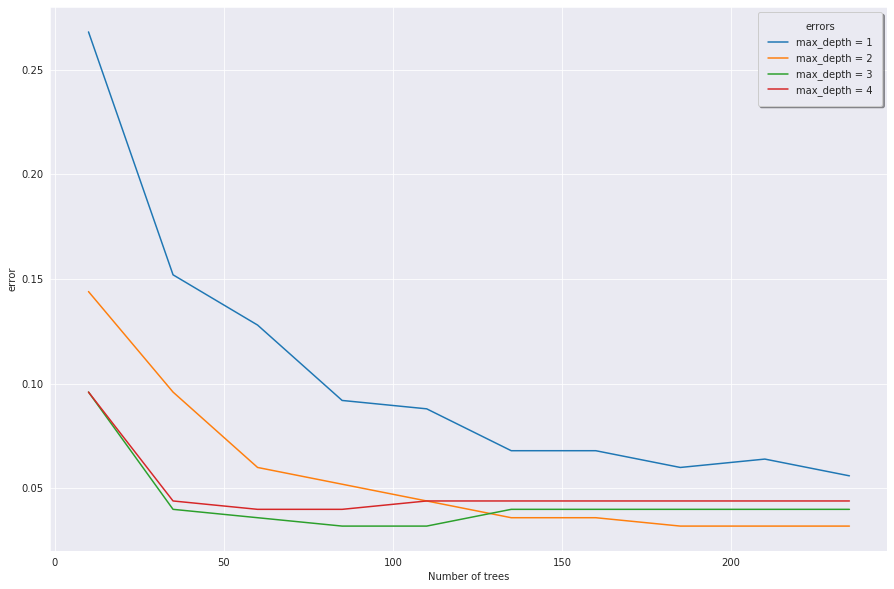

In [21]:
fig = plt.figure(figsize=(15, 10))
for i in range(d_):
    ax = sns.lineplot(estimators, y=errors[i], label=f"max_depth = {i + 1}")

    ax.set_xlabel("Number of trees")
    ax.set_ylabel("error")
    ax.legend(loc="upper right", fancybox=True, framealpha=1, shadow=True, borderpad=1, title="errors")

#### A: Beste Parameter sind: Viele Bäume mit maximaler Tiefe 4.